In [1]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from PIL import Image

from dataset import prepare_dataset
import utils
from utils import get_mean_std
from dataloader import get_datasets, get_loader, loader_dist, focus_blur_ds, show_batch
from model import ResNet
from train import train_net
from test import test_net

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
data_dir = './FocusPath_Full/'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


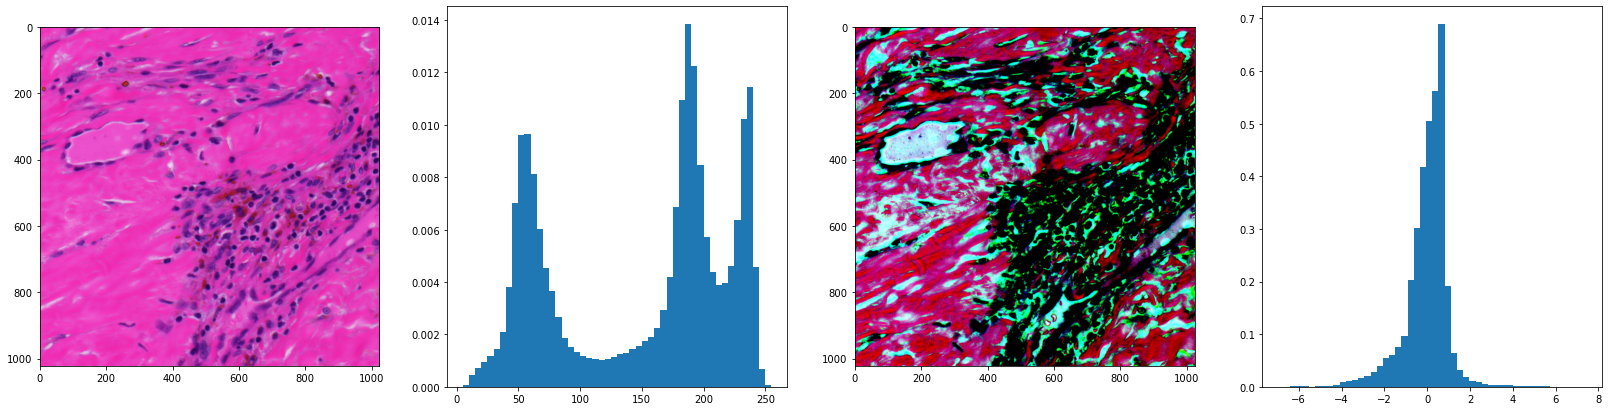

In [3]:
show_dir = os.path.join(data_dir, 'train/1/')
img_name = os.listdir(show_dir)[20]
img_path = os.path.join(show_dir, img_name)
utils.show_img(img_path)

In [4]:
mean, std = get_mean_std()
train_ds, valid_ds, test_ds = get_datasets(crop_size=512, norm=True, mean=mean, std=std)

Calculating mean and std: 100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


In [5]:
focused_ds, blur_ds = focus_blur_ds(test_ds)
focus_dl = DataLoader(focused_ds, batch_size=64, shuffle=True, num_workers=28)
blur_dl = DataLoader(blur_ds, batch_size=64, shuffle=True, num_workers=28)
val_loader = DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=28, pin_memory=True)

In [6]:
net = ResNet(3, 2)
net = net.to(device)

In [7]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=16, pin_memory=True)

In [8]:
checkpoint = torch.load('./model_weights/model_weights_1.pth')
net.load_state_dict(checkpoint['model_state_dict'])
accs = test_net(net, test_loader)

Running on test set: 100%|██████████| 1728/1728 [00:08<00:00, 208.42it/s]

Accuracy on test: 0.9091	 Time: 8.97


In [9]:
for batch_idx, (test_data, test_target) in enumerate(test_loader):
    net.eval()  

    test_data = test_data.to(device)
    test_target = test_target.to(device)  
    test_pred = net(test_data)
    _, preds = torch.max(test_pred, dim=1)
    test_acc = utils.accuracy(test_pred, test_target)
    print(test_pred)
    print(preds.item())
    print(test_acc)
    break

tensor([[ 3.6068, -3.0434]], device='cuda:0', grad_fn=<AddmmBackward>)
0
tensor(1.)


In [10]:
def evaluate(model, test_loader):
    test_accs = []
    false_pos = []
    false_neg = []
    start = time()
#     print('Running on test set...')
    loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=True)
    
    for batch_idx, (test_data, test_target) in loop:
        model.eval()  

        test_data = test_data.to(device)
        test_target = test_target.to(device)  
        test_pred = model(test_data)
        _, preds = torch.max(test_pred, dim=1)
        test_acc = utils.accuracy(test_pred, test_target)  
        test_accs.append(test_acc.item())
        if not test_acc:
            if not preds.item():
                false_neg.append(batch_idx)
            else:
                false_pos.append(batch_idx)
        
        loop.set_description('Running on test set')
        
    avg_test_acc = torch.tensor(test_accs).mean().item()
    end_time = time() - start
    print(f'Accuracy on test: {round(avg_test_acc, 4)}\t Time: {round(end_time, 2)}')
    
    return false_pos, false_neg

In [11]:
false_pos, false_neg = evaluate(net, test_loader)

Running on test set: 100%|██████████| 1728/1728 [00:07<00:00, 219.12it/s]

Accuracy on test: 0.9091	 Time: 8.43


In [14]:
_, _, test_show = get_datasets(crop_size=512)

In [15]:
false_pos_ds = torch.utils.data.Subset(test_show, false_pos)
false_neg_ds = torch.utils.data.Subset(test_show, false_neg)

In [17]:
false_pos_dl = DataLoader(false_pos_ds, batch_size=len(false_pos_ds), pin_memory=True, shuffle=False)
false_neg_dl = DataLoader(false_neg_ds, batch_size=len(false_neg_ds), pin_memory=True, shuffle=False)

### False Positive Samples

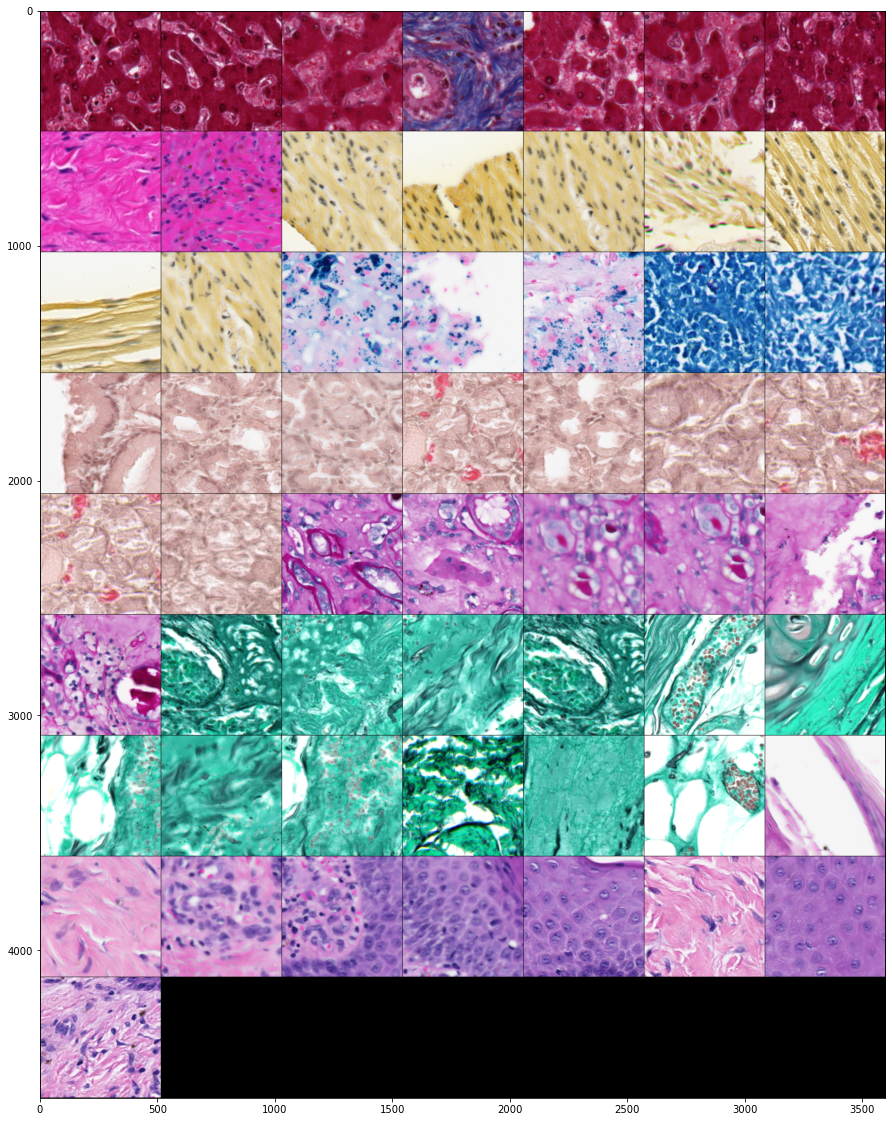

In [20]:
show_batch(false_pos_dl, figsize=20)

### False Negative Samples

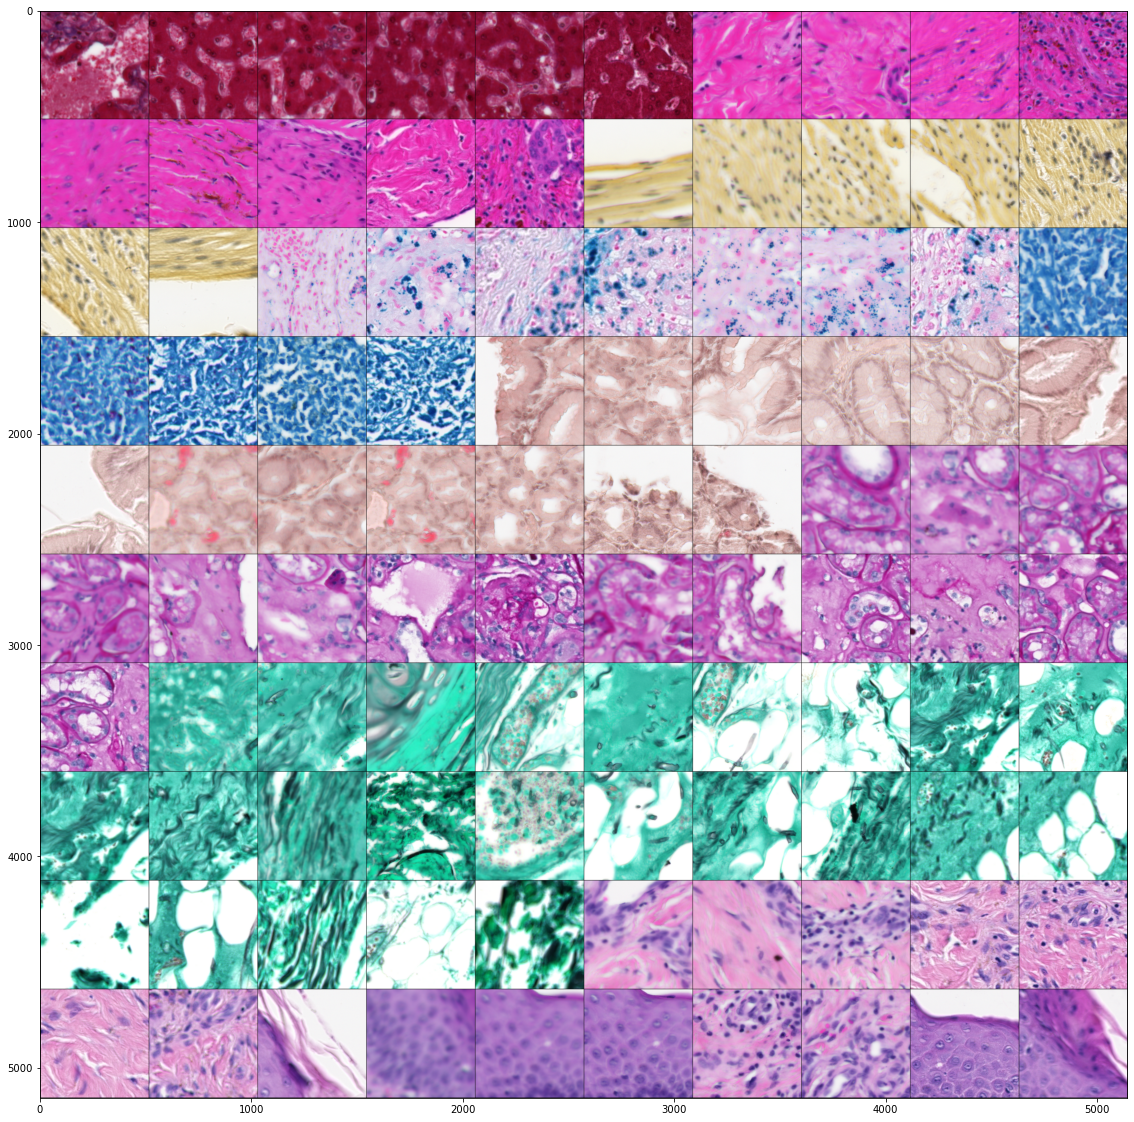

In [21]:
show_batch(false_neg_dl, figsize=20)